In [59]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import kagglehub
from tqdm import tqdm
import numpy as np
import requests
from IPython.display import clear_output
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import json
from datasets import load_dataset
from wordcloud import WordCloud
import re
import collections
import string
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
import pkg_resources
version = pkg_resources.get_distribution("datasets").version
version

ContextualVersionConflict: (fsspec 2025.3.0 (/usr/local/lib/python3.11/dist-packages), Requirement.parse('fsspec[http]<=2024.12.0,>=2023.1.0'), {'datasets'})

In [7]:
# PARAMS
MAX_LENGTH = 400
BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0.1

# Load data

### Baudelaire

In [47]:
path = "https://raw.githubusercontent.com/AmelNozieres/NLP_Generate_poems/master/Les_fleurs_du_mal_Baudelaire"
response = requests.get(path)
poems = response.text

In [8]:
path = "https://raw.githubusercontent.com/AmelNozieres/NLP_Generate_poems/master/Les_fleurs_du_mal_Baudelaire"
response = requests.get(path)
poems = response.text
corpus = poems.lower().split("\n")
corpus = [text.translate(str.maketrans('', '', string.punctuation)) for text in corpus]
vocab = poems.split(' ')
vocab = [element.strip() for element in vocab]
chars = sorted(list(set(vocab)))
chars = [element.replace('\n', '') for element in chars]

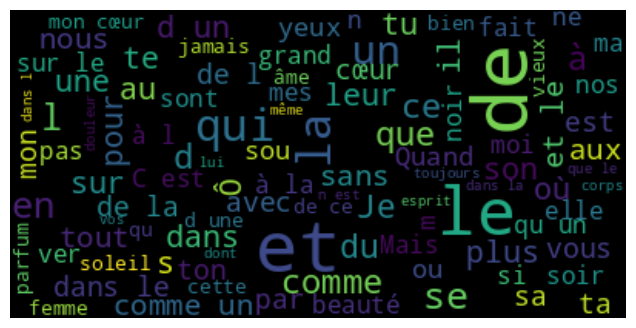

In [9]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="black").generate(poems)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

### Kaggle dataset

In [62]:
path = kagglehub.dataset_download("michaelarman/poemsdataset")
print(path)

KaggleApiHTTPError: 404 Client Error.

Resource not found at URL: https://www.kaggle.com/datasets/michaelarman/poemsdataset/versions/1
The server reported the following issues: Not found
Please make sure you specified the correct resource identifiers.

In [64]:
!pip install mlcroissant

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.0/140.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.9/564.9 kB 29.6 MB/s eta 0:00:00
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15130 sha256=5e1949911ff1dbc31fc871a4dd19633b4b009ec9c4fbb7d347e14a5f0793403a
  Stored in directory: /root/.cache/pip/wheels/53/cf/51/a4ea10224b7fdb523e18e2033cadf2a8657517d1f95f3f5413
Successfully built jsonpath-rw


In [60]:
def load_poems_from_directory(root_dir):
    """
    Load poems from a directory with 'forms' and 'topics' main folders
    Returns list of dicts with poem info
    """
    poems_data = []

    # Iterate through main categories (forms and topics)
    for main_category in ['forms', 'topics']:
        main_path = os.path.join(root_dir, main_category)
        if not os.path.exists(main_path):
            print(f"Warning: {main_path} not found")
            continue

        # Iterate through subfolders (abc, love, etc.)
        for sub_category in os.listdir(main_path):
            sub_path = os.path.join(main_path, sub_category)
            if os.path.isdir(sub_path):
                # Read each poem file in the subfolder
                for filename in os.listdir(sub_path):
                    if filename.endswith('.txt'):
                        file_path = os.path.join(sub_path, filename)
                        try:
                            with open(file_path, 'r', encoding='utf-8') as f:
                                poem_text = f.read().strip()
                                if len(poem_text.split()) >= 5:  # Filter very short texts
                                    poems_data.append({
                                        'text': poem_text,
                                        'main_category': main_category,
                                        'sub_category': sub_category,
                                        'title': filename.replace('.txt', '')
                                    })
                        except Exception as e:
                            print(f"Error reading {file_path}: {str(e)}")

    print(f"Loaded {len(poems_data)} poems:")
    print(f"- Forms: {sum(1 for p in poems_data if p['main_category'] == 'forms')}")
    print(f"- Topics: {sum(1 for p in poems_data if p['main_category'] == 'topics')}")
    return poems_data

FileNotFoundError: Unable to find 'https://raw.githubusercontent.com/AmelNozieres/NLP_Generate_poems/master/Les_fleurs_du_mal_Baudelaire/poems.csv'

In [57]:
path = kagglehub.dataset_download("michaelarman/poemsdataset")
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")


100%|██████████| 15.5M/15.5M [00:01<00:00, 16.0MB/s]

Extracting files...


OSError: [Errno 36] File name too long: '/root/.cache/kagglehub/datasets/michaelarman/poemsdataset/versions/1/topics/racism/RacismPoemsTranslationOfRacismIsAroundMeEverywhereByFrancisDugganαªåαª«αª░αªÜαª░αª¬αª╢αª¢αº£αºƒαªåαª¢αª£αªñαª¼αªªαª¼αª╖αª«αª▓αª½αª░αª¿αª╕αª╕αªíαªùαª¿PoembyAlamSayed.txt'

In [ ]:
df = pd.DataFrame(columns=['file_title','content', 'theme'])

def extract_author(x):
    expr = r'(?<=by)(.*)(?=.txt)'
    author = re.findall(expr, x)[0]
    upper_separator = re.findall('[A-Z][^A-Z]*', author)
    if len(upper_separator) > 0 :
        author = ' '.join(upper_separator)
    return author


def extract_title(x):
    expr = r'(?<=oems)(.*)(?=Poemby)'
    title = re.findall(expr, x)
    if len(title) > 0:
        upper_separator = re.findall('[A-Z][^A-Z]*', title[0])
        if len(upper_separator) > 0 :
            title = ' '.join(upper_separator)
    else :
        title = np.nan
    return title

# Iteration over topics
for subdir, _, files in os.walk(rootdir):
    theme = os.path.basename(os.path.normpath(subdir))
    content = []
    titles = []

    for file in files:
        f = os.path.join(subdir, file)
        if os.path.isfile(f):
            my_file = open(f, "r")
            content.append(my_file.read())
            titles.append(file)

    df_theme = pd.DataFrame({"file_title" : titles, "content" : content})
    df_theme['theme'] = theme
    df = pd.concat([df, df_theme], ignore_index=True)

df['author'] = df['file_title'].apply(extract_author)
df['title'] = df['file_title'].apply(extract_title)
df = df[['title', 'author', 'content', 'theme', 'file_title']]

# Exploratory Data Analysis

### Baudelaire

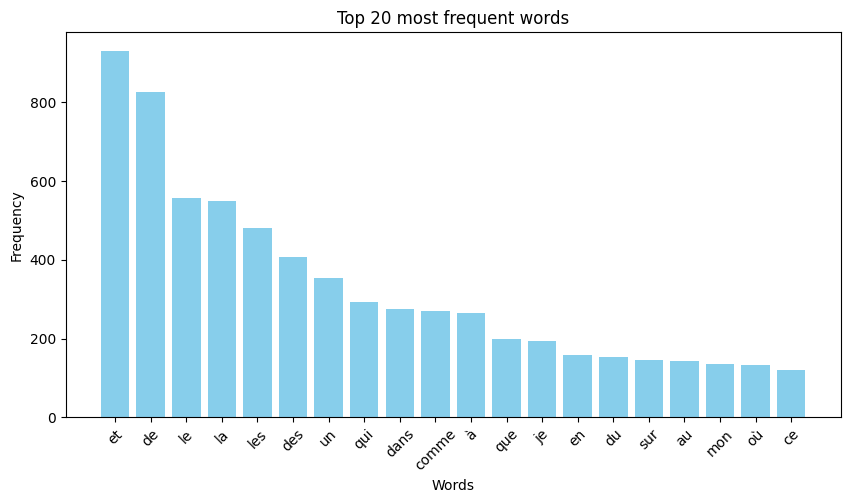

In [13]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

word_counts = collections.Counter()
for sentence in corpus:
    word_counts.update(preprocess(sentence))

most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

# plot
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 most frequent words")
plt.xticks(rotation=45)
plt.show()

In [54]:
df

,title,author,content,theme,file_title


### Kaggle dataset

In [53]:
print("There are {} different themes in the database :".format(len(df['theme'].unique())))

df['theme'].unique()

There are 0 different themes in the database :




array([], dtype=object)

# Generation using the library Transformers

In [58]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

NameError: name 'GPT2TokenizerFast' is not defined

In [46]:
json_data = json.dumps(poems)
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")
dataset = load_dataset("json", data_files={"train": json_data})

Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [30]:
input_text = "generate poem: " + poems
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

In [35]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [36]:
output = model.generate(**inputs, max_length=100, num_return_sequences=1, temperature=0.7)

# Décoder la sortie
generated_poem = tokenizer.decode(output[0], skip_special_tokens=True)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [37]:
print("\n📝 Poème généré :\n", generated_poem)


📝 Poème généré :
 ,,,,,,,, la lésine, Occupent nos esprits et travaillent nos corps, Et nous alimentons nos aimables remords, Comme les mendiants nourrissent leur vermine ; Nous alimentons nos aimables remords, Comme les mendiants nourrissent leur vermine ; Nous 


# DataLoader

In [ ]:
class PoemDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenisation
        encoding = self.tokenizer(text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length=self.max_length,
                                  return_tensors="pt")

        # Retourne les IDs et le masque d'attention
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0)
        }

In [ ]:
dataset = PoemDataset(poems, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Model

In [ ]:
len(max(chars))

10

In [ ]:
class LSTMPoemGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(LSTMPoemGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim))


# Dataset

In [ ]:
class PoetryDataset(Dataset):
    def __init__(self, corpus, tokenizer, max_length, device):
        self.input_ids = []
        self.attn_masks = []

        for line in tqdm(corpus):
            # Format text with hierarchical categories

            encodings = tokenizer(
                line,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                return_tensors='pt'
            )

            self.input_ids.append(encodings['input_ids'][0].to(device))
            self.attn_masks.append(encodings['attention_mask'][0].to(device))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
        }

# Train the model

In [ ]:
# Paramètres
seq_length = 50
batch_size = 32
embed_dim = 128
hidden_dim = 256
num_layers = 5
lr = 0.001

# Charger les données
dataset = PoetryDataset(corpus=corpus, tokenizer=tokenizer, max_length=len(max(chars))+1, device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialiser le modèle
model = LSTMPoemGenerator(vocab_size=len(chars), embed_dim=embed_dim, hidden_dim=hidden_dim, num_layers=num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Entraînement
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        inputs = torch.tensor([tokenizer.encode(text) for text in inputs], dtype=torch.long).to(device)
        targets = torch.tensor([tokenizer.encode(text) for text in targets], dtype=torch.long).to(device)
        hidden = model.init_hidden(batch_size)
        outputs, hidden = model(inputs, hidden)

        # Reshape pour correspondre aux dimensions de la loss
        loss = criterion(outputs.view(-1, len(vocab)), targets.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


100%|██████████| 3575/3575 [00:00<00:00, 26121.19it/s]


RuntimeError: Expected hidden[0] size (5, 9, 256), got [1, 32, 256]

In [ ]:
def generate_text(model, start_text, length=50):
    model.eval()
    words = tokenizer(start_text)
    input_seq = torch.tensor([text_to_sequence(start_text)], dtype=torch.long)

    hidden = model.init_hidden(1)

    for _ in range(length):
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)
            predicted_index = torch.argmax(output[:, -1, :], dim=-1).item()
            words.append(vocab.lookup_token(predicted_index))

        input_seq = torch.tensor([[predicted_index]], dtype=torch.long)

    return " ".join(words)

print(generate_text(model, "Dans le silence", length=50))

Epoch 1/10 | Batch 615/1788 | Loss: 6.1201 | Time: 468.60s


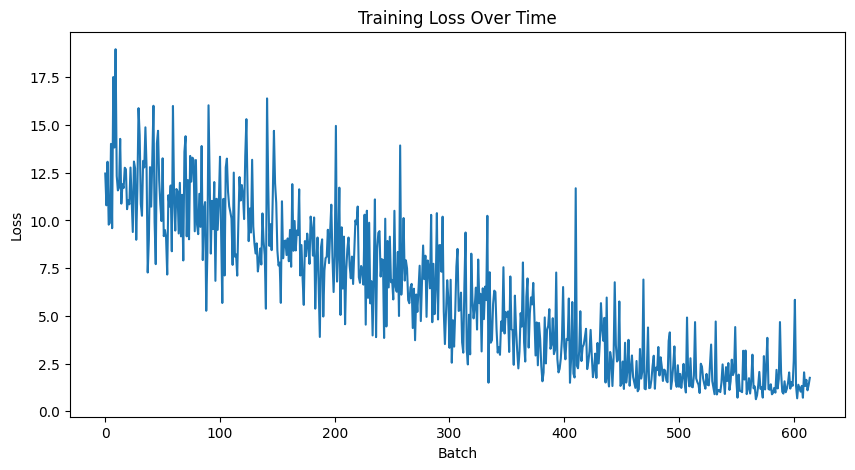

  0%|          | 0/10 [07:51<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model.train()
total_start_time = time.time()
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_start_time = time.time()
    total_loss = 0
    batch_times = []

    for batch_num, batch in enumerate(train_dataloader, 1):
        batch_start_time = time.time()

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )
            loss = outputs.loss

        total_loss += loss.item()
        losses.append(loss.item())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()

        # Display progress
        if batch_num % 5 == 0:
            clear_output(wait=True)
            elapsed_time = time.time() - epoch_start_time
            avg_loss = total_loss / batch_num
            print(f'Epoch {epoch+1}/{EPOCHS} | Batch {batch_num}/{len(train_dataloader)} | '
                  f'Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}s')

            # Plot loss curve
            plt.figure(figsize=(10, 5))
            plt.plot(losses)
            plt.title('Training Loss Over Time')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.show()